In [15]:
!hostname

login-q-4


In [16]:
import sys
import os

# Add the root directory to the system path
root_dir = os.path.abspath("..")  # Assuming the notebook is one level deep in the 'notebooks' directory
if root_dir not in sys.path:
    sys.path.append(root_dir)

In [17]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, QED
from rdkit.Chem import Draw
from rdkit.Chem.rdchem import MolSanitizeException
import random

In [4]:
enamine_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_building_blocks.csv")
rxn_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/rxn_set_processed.txt", delimiter="|")

# Random search baseline

In [5]:
enamine_df.head()

,SMILES
0,CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C...
1,CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c...
2,CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)...
3,CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(...
4,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...


# Random Search Result EXploration

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [62]:
results = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/raw_data/random_molsearch_results.csv")

In [63]:
results.head()

,step,reactant,template,product,qed,second_reactant
0,0,Cc1nnnn1CCCCl,NaN,Cc1nnnn1CCCCl,0.608998,NaN
1,1,Cc1nnnn1CCCCl,Williamson_ether,Cc1nnnn1CCCOC1(CCCN)CCC1,0.700502,NCCCC1(O)CCC1
2,2,Cc1nnnn1CCCOC1(CCCN)CCC1,Quinazolinone_formation,Cc1nnnn1CCCOC1(CCCn2cnc3c(F)cccc3c2=O)CCC1,0.513306,Nc1c(F)cccc1C(=O)O
3,0,O=C(O)C1NCCc2c1[nH]c1ccccc21,NaN,O=C(O)C1NCCc2c1[nH]c1ccccc21,0.675425,NaN
4,1,O=C(O)C1NCCc2c1[nH]c1ccccc21,FGI_Acyl_chloride,O=C(Cl)C1NCCc2c1[nH]c1ccccc21,0.742808,NaN


In [64]:
results.describe()

,step,qed
count,14269.000000,14269.000000
mean,1.497862,0.524127
std,1.439928,0.246830
min,0.000000,0.014252
25%,0.000000,0.315891
50%,1.000000,0.582752
75%,2.000000,0.724659
max,5.000000,0.944888


In [65]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14269 entries, 0 to 14268
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   step             14269 non-null  int64  
 1   reactant         14269 non-null  object 
 2   template         10000 non-null  object 
 3   product          14269 non-null  object 
 4   qed              14269 non-null  float64
 5   second_reactant  7896 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 669.0+ KB


In [127]:
# Identify unique products that are not in the list of reactants
reactants_set = set(results['reactant'].unique())
unique_products = [product for product in results['product'].unique() if product not in reactants_set]
    
# Calculate QED for each unique product
unique_products_qed = []
for product in unique_products:
    mol = Chem.MolFromSmiles(product)
    if mol:
        qed = QED.qed(mol)
        unique_products_qed.append((product, qed))

# Create DataFrame and sort by QED
unique_products_df = pd.DataFrame(unique_products_qed, columns=['Product', 'QED']).sort_values(by='QED', ascending=False)

# Display unique products
print("Unique Products and Their QED Values:")
unique_products_df

Unique Products and Their QED Values:


,Product,QED
707,O=c1c2cccc(F)c2nc(C2CSCN2)n1CC1CC1,0.944888
2038,CC(C)(C)c1cnc(Oc2ccc(F)cc2C(N)=O)cn1,0.942005
140,NC(=O)c1ccc(Cn2c(C3CC3)cc3c2CCCC3)o1,0.937830
2783,FC(F)(F)c1ccc(C(c2nn[nH]n2)N2CCOCC2)cc1,0.932917
1700,CCN(C)C(=O)c1ccc(CN2CC(=O)Nc3cc(C)cnc32)cc1,0.929834
...,...,...
3172,CCC(C)C(NCc1c[nH]c2nccc(Cl)c12)C(=O)NC[C@H](CC...,0.017361
3346,CCOC(=O)C12CN(c3ccccc3)CCC1(c1c(-c3ccc(C(C)C)c...,0.016553
2784,CCCCCNCc1cccc(OC(=O)c2[nH]c3ccccc3c2C23CCN(c4c...,0.015734
3237,CCCn1c(C2(C(c3[nH]c4c([N+](=O)[O-])cc(S(=O)(=O...,0.015153


In [81]:
# Set up seaborn style without grid lines
sns.set(style="white", palette="muted", color_codes=True)

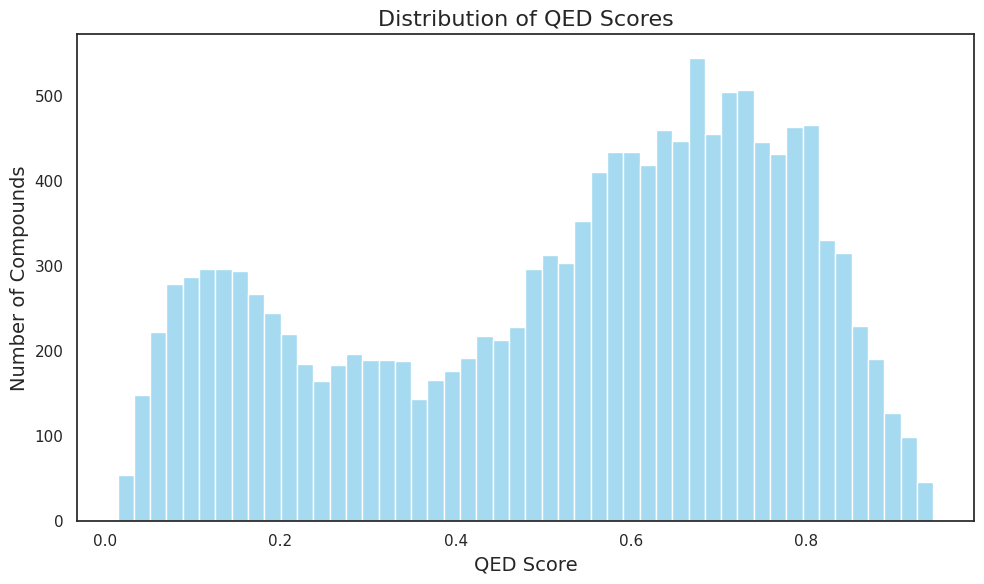

In [94]:
# Plot QED scores
plt.figure(figsize=(10, 6))
sns.histplot(results['qed'].dropna(), bins=50, kde=False, color='skyblue')
plt.title('Distribution of QED Scores', fontsize=16)
plt.xlabel('QED Score', fontsize=14)
plt.ylabel('Number of Compounds', fontsize=14)
plt.tight_layout()
plt.show()

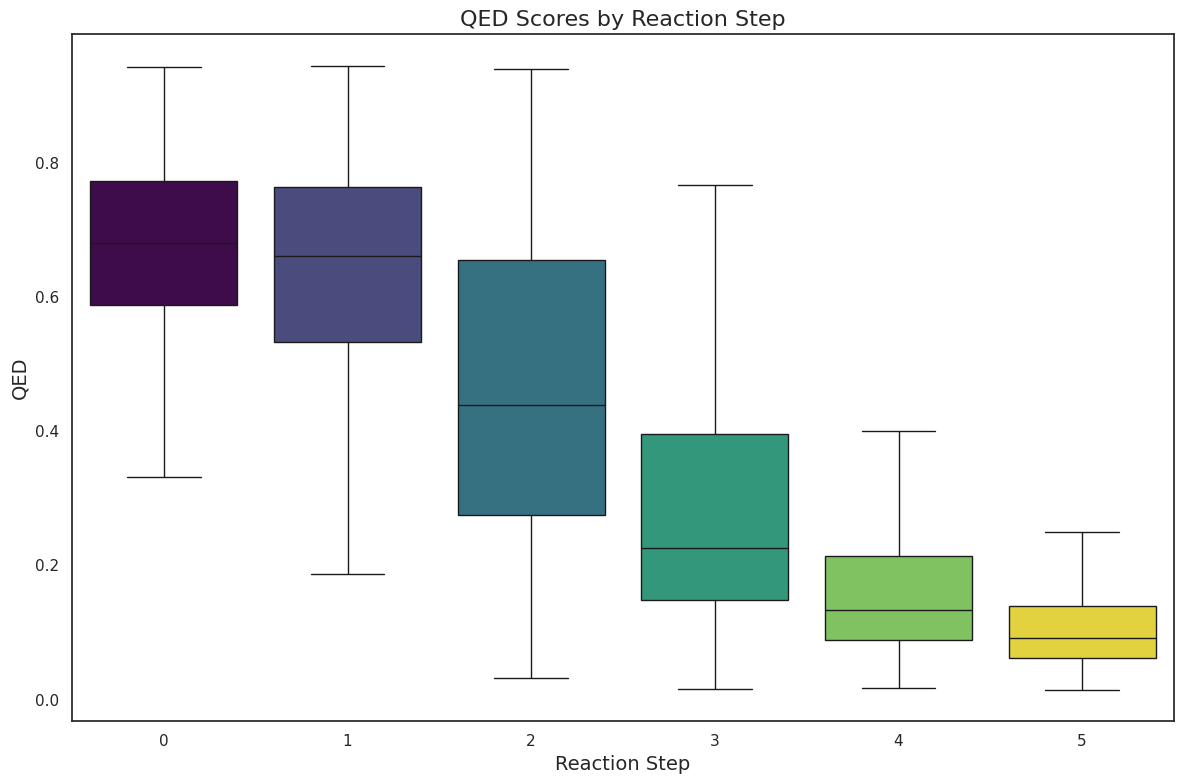

In [90]:
# Box plot for QED scores by reaction step with customized settings to avoid FutureWarning
plt.figure(figsize=(12, 8))
sns.boxplot(x='step', y='qed', data=results, hue='step', palette="viridis", showfliers=False, dodge=False)
plt.legend([], [], frameon=False)  # Remove legend
plt.title('QED Scores by Reaction Step', fontsize=16)
plt.xlabel('Reaction Step', fontsize=14)
plt.ylabel('QED', fontsize=14)
plt.tight_layout()
plt.show()


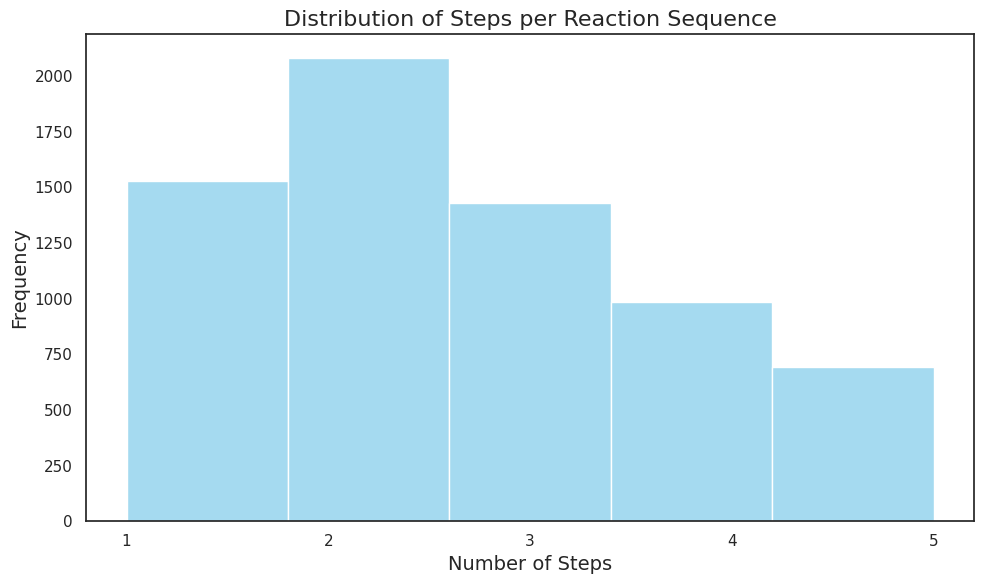

In [98]:
# Plot steps per reaction sequence
steps_per_sequence = results.groupby('reactant')['step'].max()

plt.figure(figsize=(10, 6))
sns.histplot(steps_per_sequence, bins=5, kde=False, color='skyblue')
plt.title('Distribution of Steps per Reaction Sequence', fontsize=16)
plt.xlabel('Number of Steps', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(1, 5 + 1))  # Set x-ticks to whole numbers
plt.tight_layout()
plt.show()

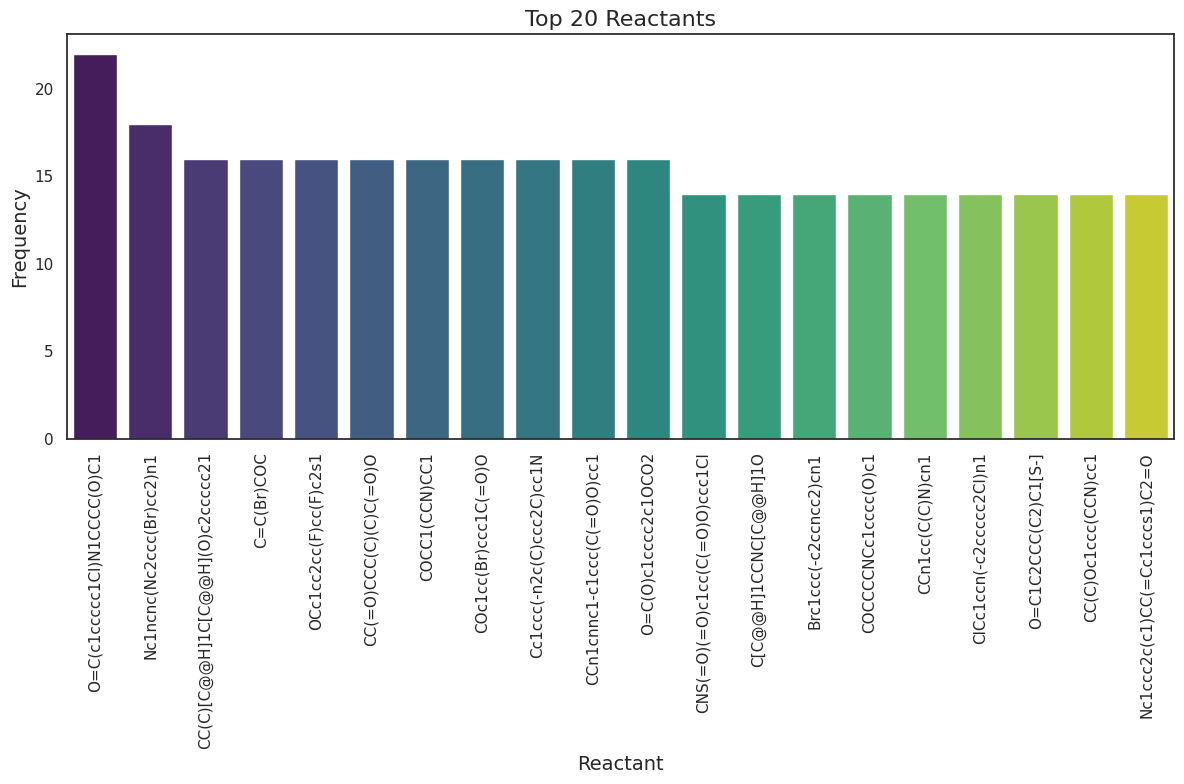

In [100]:
# Plot top 20 reactants
reactants = results['reactant'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=reactants.head(20).index, hue=reactants.head(20).index, y=reactants.head(20).values, palette='viridis')
plt.title('Top 20 Reactants', fontsize=16)
plt.xlabel('Reactant', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

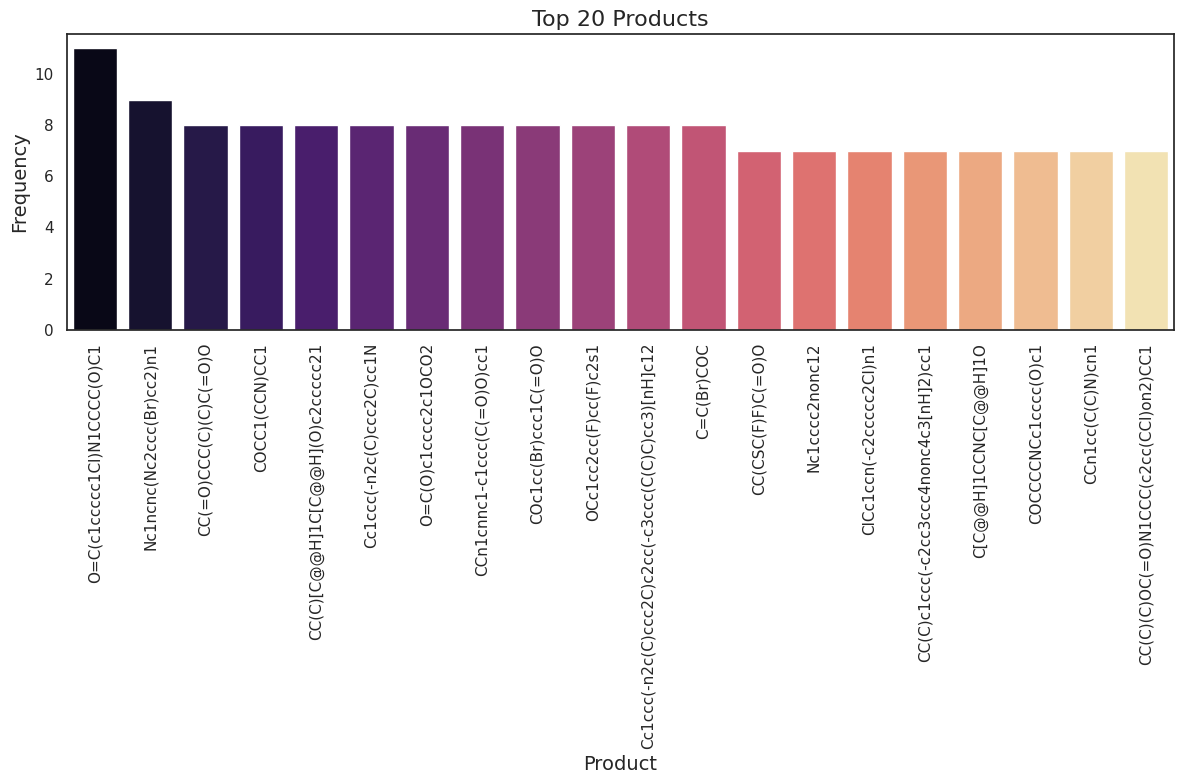

In [102]:
# Plot top 20 products
products = results['product'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=products.head(20).index, hue=products.head(20).index, y=products.head(20).values, palette='magma')
plt.title('Top 20 Products', fontsize=16)
plt.xlabel('Product', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

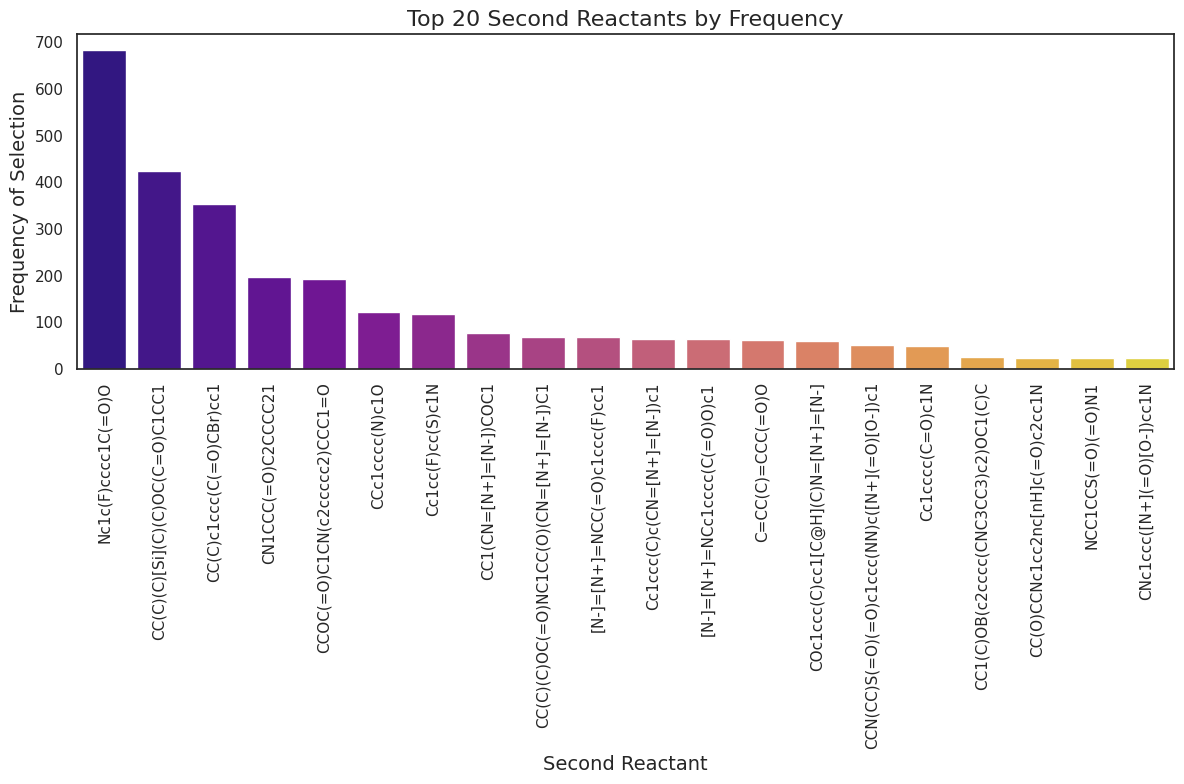

In [103]:
# Plot top 20 second reactants by frequency of selection in bimolecular reactions
second_reactants = results['second_reactant'].dropna().value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=second_reactants.head(20).index, hue=second_reactants.head(20).index, y=second_reactants.head(20).values, palette='plasma')
plt.title('Top 20 Second Reactants by Frequency', fontsize=16)
plt.xlabel('Second Reactant', fontsize=14)
plt.ylabel('Frequency of Selection', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

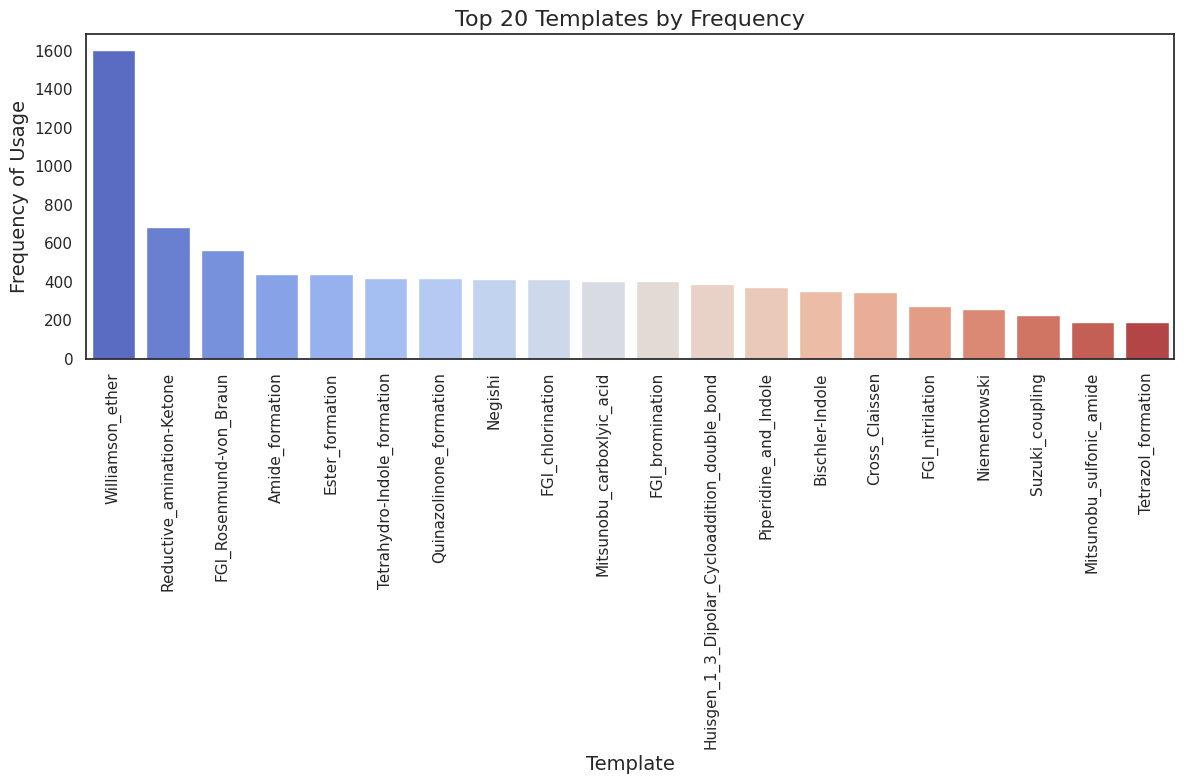

In [105]:
# Plot template usage frequency
templates = results['template'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=templates.head(20).index, hue=templates.head(20).index, y=templates.head(20).values, palette='coolwarm')
plt.title('Top 20 Templates by Frequency', fontsize=16)
plt.xlabel('Template', fontsize=14)
plt.ylabel('Frequency of Usage', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [108]:
# Identify the product with the highest QED score
max_qed_row = results.loc[results['qed'].idxmax()]
highest_qed_product = max_qed_row['product']
highest_qed_sequence = results[results['product'] == highest_qed_product].drop_duplicates()

In [109]:
highest_qed_sequence

,step,reactant,template,product,qed,second_reactant
2411,1,O=C(NCC1CC1)C1CSCN1,Niementowski,O=c1c2cccc(F)c2nc(C2CSCN2)n1CC1CC1,0.944888,Nc1c(F)cccc1C(=O)O


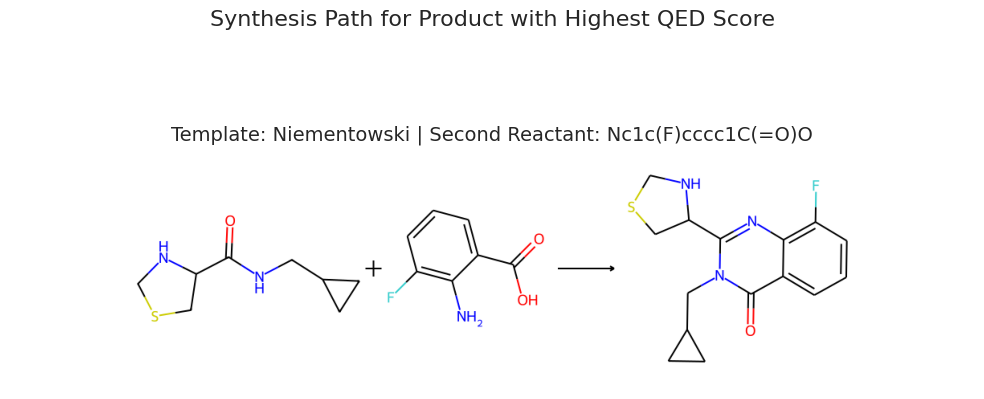

In [118]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import ReactionToImage
from rdkit.Chem import AllChem

# Visualize the synthesis path using RDKit
synthesis_path = []
for _, row in highest_qed_sequence.iterrows():
    synthesis_path.append((row['reactant'], row['product'], row['template'], row['second_reactant'] if 'second_reactant' in row else None))

# Generate reaction images
reactions = []
for reactant, product, template, second_reactant in synthesis_path:
    if second_reactant and pd.notna(second_reactant):
        reactants = [Chem.MolFromSmiles(reactant), Chem.MolFromSmiles(second_reactant)]
    else:
        reactants = [Chem.MolFromSmiles(reactant)]
    products = [Chem.MolFromSmiles(product)]
    rxn = AllChem.ChemicalReaction()
    for r in reactants:
        rxn.AddReactantTemplate(r)
    for p in products:
        rxn.AddProductTemplate(p)
    reactions.append(rxn)

# Draw the reactions
reaction_images = [ReactionToImage(rxn, subImgSize=(300, 300)) for rxn in reactions]
    
# Display the reaction images
fig, axes = plt.subplots(len(reaction_images), 1, figsize=(10, 5 * len(reaction_images)))
if len(reaction_images) == 1:
    axes = [axes]
for ax, img, (reactant, product, template, second_reactant) in zip(axes, reaction_images, synthesis_path):
    ax.imshow(img)
    ax.axis('off')
    title = f"Template: {template}"
    if second_reactant and pd.notna(second_reactant):
        title += f" | Second Reactant: {second_reactant}"
    ax.set_title(title, fontsize=14)

plt.suptitle('Synthesis Path for Product with Highest QED Score', fontsize=16)
plt.tight_layout()
plt.show()


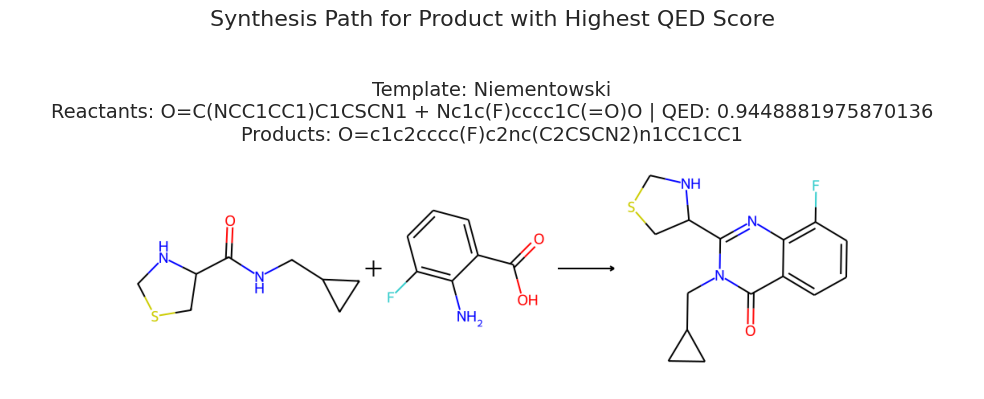

In [119]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import ReactionToImage
from rdkit.Chem import AllChem

# Visualize the synthesis path using RDKit
synthesis_path = []
for _, row in highest_qed_sequence.iterrows():
    synthesis_path.append((row['reactant'], row['product'], row['template'], row['second_reactant'], row['qed']))

# Generate reaction images
reactions = []
for reactant, product, template, second_reactant, qed in synthesis_path:
    if second_reactant and pd.notna(second_reactant):
        reactants = [Chem.MolFromSmiles(reactant), Chem.MolFromSmiles(second_reactant)]
    else:
        reactants = [Chem.MolFromSmiles(reactant)]
    products = [Chem.MolFromSmiles(product)]
    rxn = AllChem.ChemicalReaction()
    for r in reactants:
        rxn.AddReactantTemplate(r)
    for p in products:
        rxn.AddProductTemplate(p)
    reactions.append((rxn, reactants, products, template, qed))

# Draw the reactions
reaction_images = []
for rxn, reactants, products, template, qed in reactions:
    img = ReactionToImage(rxn, subImgSize=(300, 300))
    reaction_images.append((img, reactants, products, template, qed))
    
# Display the reaction images
fig, axes = plt.subplots(len(reaction_images), 1, figsize=(10, 5 * len(reaction_images)))
if len(reaction_images) == 1:
    axes = [axes]
for ax, (img, reactants, products, template, qed) in zip(axes, reaction_images):
    ax.imshow(img)
    ax.axis('off')
    reactants_str = ' + '.join([Chem.MolToSmiles(mol) for mol in reactants])
    products_str = ' + '.join([Chem.MolToSmiles(mol) for mol in products])
    title = f"Template: {template}\nReactants: {reactants_str} | QED: {qed}\nProducts: {products_str}"
    ax.set_title(title, fontsize=14)

plt.suptitle('Synthesis Path for Product with Highest QED Score', fontsize=16)
plt.tight_layout()
plt.show()


# Modified RandomMolSearch

In [18]:
mols_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/results/Rmolsearch_results_1000.csv", index_col=0)

In [19]:
mols_df.head()

,step,reactant,template,product,qed,second_reactant
path_id,,,,,,
0,0,O=C(O)c1nccnc1NCC1CCCOC1,NaN,O=C(O)c1nccnc1NCC1CCCOC1,0.813,NaN
0,1,O=C(O)c1nccnc1NCC1CCCOC1,Mitsunobu_carboxlyic_acid,C=COc1ccc(COC(=O)c2nccnc2NCC2CCCOC2)cc1,0.565,C=COc1ccc(CO)cc1
1,0,Nc1cc(-c2ccccc2)ccc1Cl,NaN,Nc1cc(-c2ccccc2)ccc1Cl,0.705,NaN
1,1,Nc1cc(-c2ccccc2)ccc1Cl,Williamson_ether,Nc1ccc2ncnc(N3CCOCC3COc3ccc(-c4ccccc4)cc3N)c2c1,0.468,Nc1ccc2ncnc(N3CCOCC3CO)c2c1
1,2,Nc1ccc2ncnc(N3CCOCC3COc3ccc(-c4ccccc4)cc3N)c2c1,Bischler-Indole,Nc1ccc2ncnc(N3CCOCC3COc3ccc(-c4ccccc4)c4cc(-c5...,0.197,O=C(CBr)c1ccccc1Br


In [20]:
mols_df.describe()

,step,qed
count,1464.000000,1464.000000
mean,1.370902,0.542335
std,1.361917,0.238131
min,0.000000,0.020000
25%,0.000000,0.365500
50%,1.000000,0.594000
75%,2.000000,0.736000
max,5.000000,0.944000


In [21]:
from src.chem.chem_utils import get_compound_name
get_compound_name(enamine_df.SMILES.tolist()[0])

'[1-[7-but-2-ynyl-3-methyl-1-[(4-methylquinazolin-2-yl)methyl]-2,6-dioxopurin-8-yl]piperidin-3-yl]urea'

In [22]:
from src.chem.synthesis_path import print_path, draw_path

In [23]:
print_path(mols_df, 1)

Synthesis Path ID: 1
Step 0:
  Reactant: Nc1cc(-c2ccccc2)ccc1Cl
  Template: nan
  Product: Nc1cc(-c2ccccc2)ccc1Cl
  QED Score: 0.705
----------------------------------------
Step 1:
  Reactant: Nc1cc(-c2ccccc2)ccc1Cl
  Second Reactant: Nc1ccc2ncnc(N3CCOCC3CO)c2c1
  Template: Williamson_ether
  Product: Nc1ccc2ncnc(N3CCOCC3COc3ccc(-c4ccccc4)cc3N)c2c1
  QED Score: 0.468
----------------------------------------
Step 2:
  Reactant: Nc1ccc2ncnc(N3CCOCC3COc3ccc(-c4ccccc4)cc3N)c2c1
  Second Reactant: O=C(CBr)c1ccccc1Br
  Template: Bischler-Indole
  Product: Nc1ccc2ncnc(N3CCOCC3COc3ccc(-c4ccccc4)c4cc(-c5ccccc5Br)[nH]c34)c2c1
  QED Score: 0.197
----------------------------------------
Step 3:
  Reactant: Nc1ccc2ncnc(N3CCOCC3COc3ccc(-c4ccccc4)c4cc(-c5ccccc5Br)[nH]c34)c2c1
  Second Reactant: OCc1ccc(Cl)c(Cl)n1
  Template: Williamson_ether
  Product: Nc1ccc2ncnc(N3CCOCC3COc3ccc(-c4ccccc4)c4cc(-c5ccccc5OCc5ccc(Cl)c(Cl)n5)[nH]c34)c2c1
  QED Score: 0.114
----------------------------------------


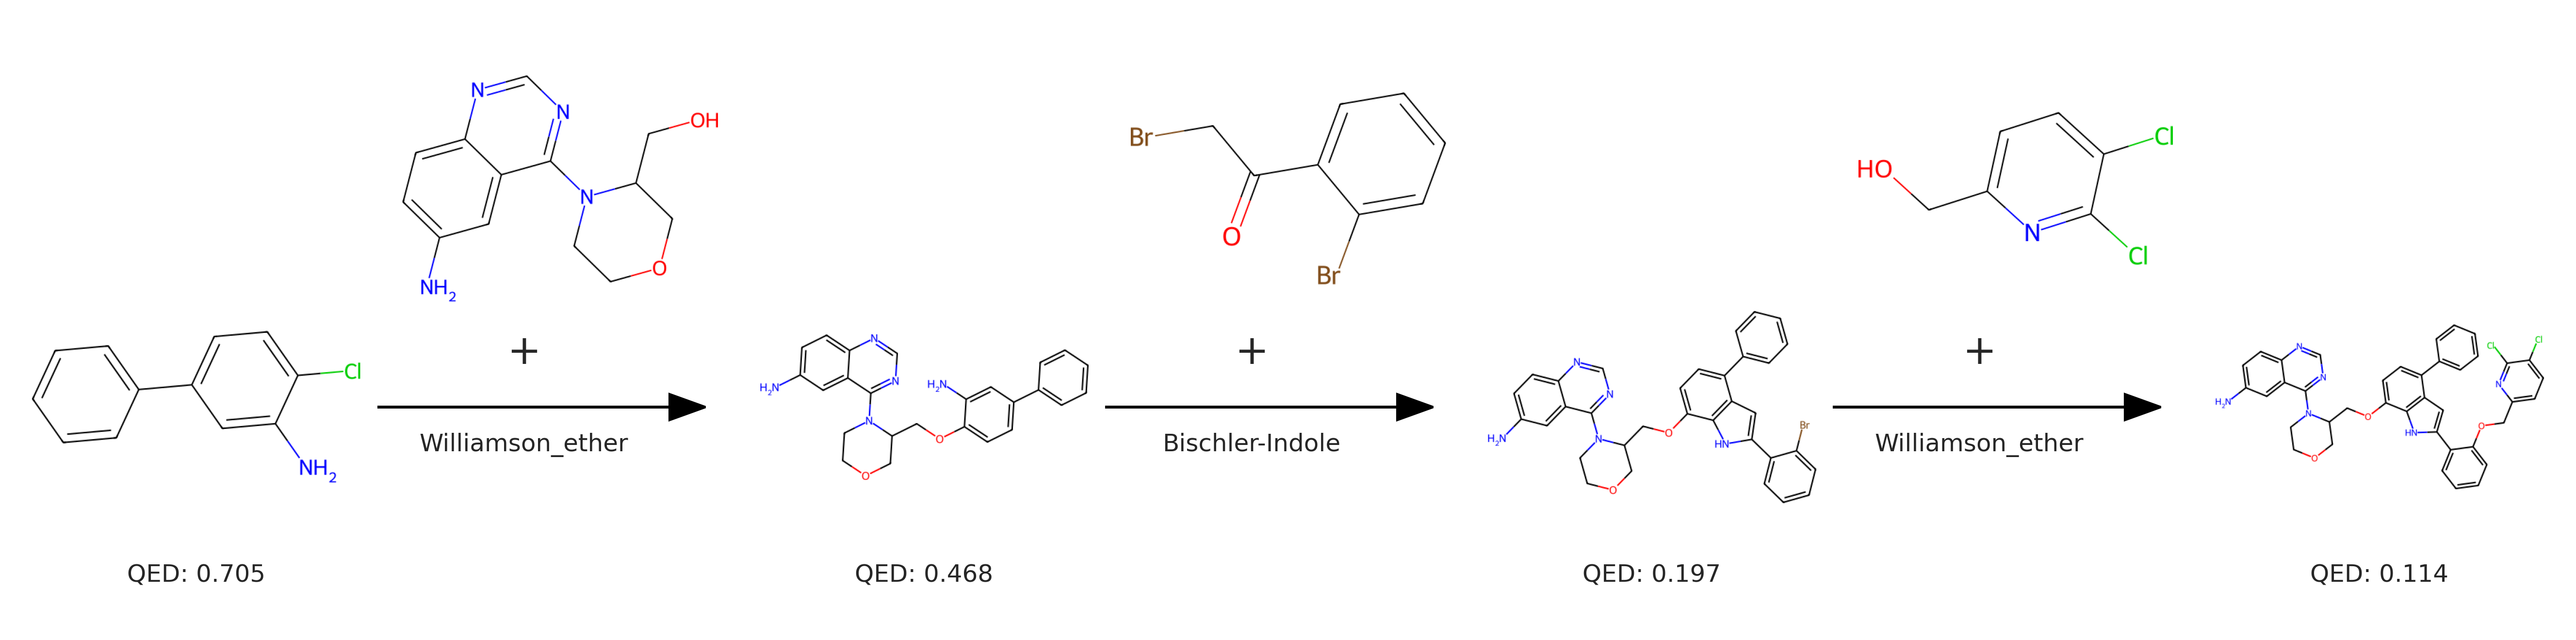

In [24]:
draw_path(mols_df, 1)